In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras_callback import LRFinder
import sklearn.metrics as metrics

In [35]:
np.random.seed(156)
img_size = (224,224)
batch_size = 64

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../../Dataset_3",
    validation_split= 0.2,
    labels = 'inferred',
    subset='training',
    seed=123,
    image_size= img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../../Dataset_3",
    validation_split= 0.2,
    labels = 'inferred',
    subset='validation',
    seed=123,
    image_size= img_size,
    batch_size=batch_size
)

Found 25077 files belonging to 2 classes.
Using 20062 files for training.
Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [97]:
y = np.concatenate([y for x, y in test_ds], axis=0)

In [98]:
print(y)

[0 1 0 ... 1 0 0]


In [56]:
class_names = train_ds.class_names
print(class_names)

['Organic', 'Recyclable']


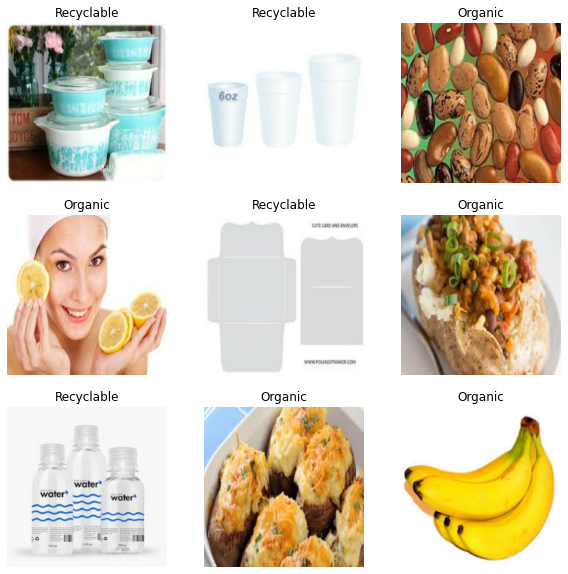

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [38]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")


def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

In [39]:
data_aug = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.125),
    ],
    name = "aug_layer"
)

In [40]:
mainmodel = tf.keras.applications.EfficientNetB0(
            input_shape= (224,224,3),
            weights='imagenet',
            include_top= False,
            )

In [41]:
model = tf.keras.Sequential(
    [
        keras.Input(shape=(224,224,3)),
        data_aug,
        mainmodel,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout (0.5),
        keras.layers.Dense(1,activation='relu'),

    ]
)
mainmodel.trainable = False

In [42]:
for layer in model.layers[-20:]:
            if not isinstance(layer,layers.BatchNormalization):
                layer.trainable = True

In [43]:
#hyperparameter : l_rate,batch_size,epoch, optimizer

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=0.7e-4)
model.compile(optimizer= optimizer, loss='binary_crossentropy',metrics=['accuracy'])

stopper = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience= 8)


In [63]:
model_run = model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=stopper)

Epoch 1/50
314/314 [==============================] - 222s 664ms/step - loss: 1.1196 - accuracy: 0.9177 - val_loss: 0.9609 - val_accuracy: 0.9314
Epoch 2/50
314/314 [==============================] - 205s 652ms/step - loss: 1.0417 - accuracy: 0.9253 - val_loss: 0.9384 - val_accuracy: 0.9332
Epoch 3/50
314/314 [==============================] - 211s 670ms/step - loss: 0.9861 - accuracy: 0.9283 - val_loss: 0.9352 - val_accuracy: 0.9320
Epoch 4/50
314/314 [==============================] - 213s 678ms/step - loss: 0.9831 - accuracy: 0.9291 - val_loss: 0.8868 - val_accuracy: 0.9364
Epoch 5/50
314/314 [==============================] - 214s 680ms/step - loss: 1.0210 - accuracy: 0.9281 - val_loss: 0.9605 - val_accuracy: 0.9326
Epoch 6/50
314/314 [==============================] - 214s 680ms/step - loss: 0.9548 - accuracy: 0.9309 - val_loss: 0.8024 - val_accuracy: 0.9404
Epoch 7/50
314/314 [==============================] - 213s 678ms/step - loss: 0.9241 - accuracy: 0.9337 - val_loss: 0.8892 -

Epoch 1/5
314/314 [==============================] - 222s 704ms/step - loss: 1.3418 - accuracy: 0.9021 - val_loss: 1.0459 - val_accuracy: 0.9214
Epoch 2/5
314/314 [==============================] - 215s 683ms/step - loss: 1.3255 - accuracy: 0.9027 - val_loss: 1.0415 - val_accuracy: 0.9224
Epoch 3/5
314/314 [==============================] - 213s 678ms/step - loss: 1.3137 - accuracy: 0.9030 - val_loss: 1.0460 - val_accuracy: 0.9214
Epoch 4/5
314/314 [==============================] - 213s 677ms/step - loss: 1.3158 - accuracy: 0.9043 - val_loss: 1.0510 - val_accuracy: 0.9212
Epoch 5/5
314/314 [==============================] - 215s 682ms/step - loss: 1.3052 - accuracy: 0.9045 - val_loss: 1.0409 - val_accuracy: 0.9214


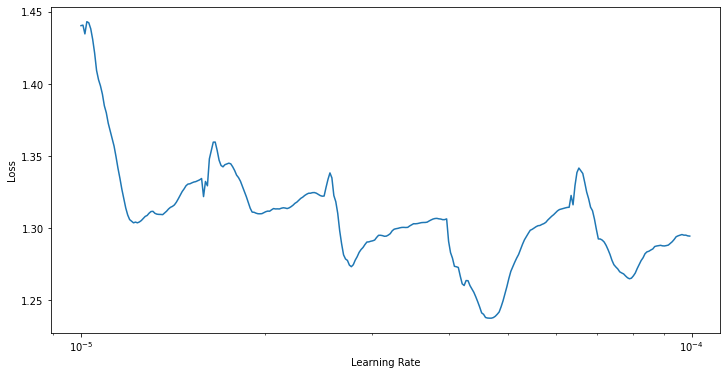

In [60]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-4)
model_run = model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=lr_finder)

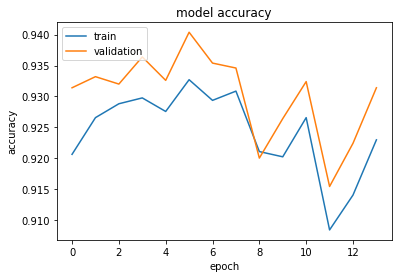

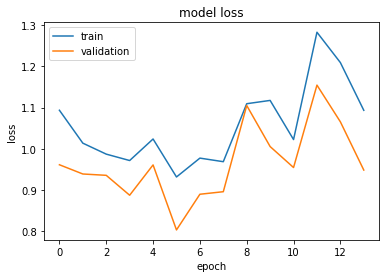

79/79 [==============================] - 15s 183ms/step - loss: 0.9480 - accuracy: 0.9314


In [64]:
plot_hist(model_run)
plt.savefig('Accuracy Curve_Final')
plt.show()

plot_hist_loss(model_run)
plt.savefig('Loss Curve_Final')
plt.show()


performance = model.evaluate(test_ds)

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aug_layer (Sequential)       (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 4,011,389
Non-trainable params: 44,583
_______________________________________

In [67]:
predictions = model.predict(test_ds)

predicted_classes = np.argmax(predictions, axis=1)

In [108]:
tf.math.confusion_matrix(labels = y,predictions = predictions)

<tf.Tensor: shape=(33, 33), dtype=int32, numpy=
array([[1550,   37,   59, ...,    0,    1,    1],
       [1321,   43,   36, ...,    0,    1,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])>

In [111]:
print(metrics.confusion_matrix(y,predicted_classes))

[[2727    0]
 [2288    0]]


In [112]:
print(predicted_classes.unique)

AttributeError: 'numpy.ndarray' object has no attribute 'unique'